Brandon Ngo <br>
This is a program that takes a dataset of Ramen and classifies the Country based on the Variety/Description of the Ramen. In this we will mainly be looking at whether or not a ramen came from Japan.

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

Libraries used in the program

In [129]:
df = pd.read_csv("ramen-ratings.csv")

Collaborator: Aleksey Bilogur
https://www.kaggle.com/datasets/residentmario/ramen-ratings/data

Sorry if my citation on the data is wrong. The data is a CSV file and should be included in my submission. I decided to use this dataset because Ramen noodles were my best friend during University and as a final tribute I will anaylze it. The data has 7 categories: Review #, Brand, Variety, Style, Country, Stars, and Top Ten. In this project we will try to predict the 'Country" based on the 'Variety'. More specifically, we want to know if our Ramen came from the country Japan based on Variety.


In [130]:
df = df.dropna(subset=["Variety", "Country"])
df.head()


,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


Above we will remove any NaN values from the categories of Variety and Stars since we wouldnt want that in our data. We will also look at the first 5 rows.

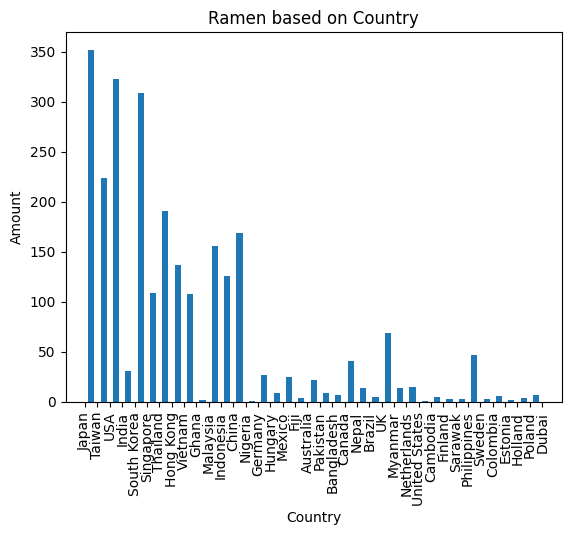

In [131]:
plt.hist(df.Country, bins = 37, rwidth=0.5)
plt.xticks(rotation='vertical')
plt.title("Ramen based on Country")
plt.ylabel("Amount")
plt.xlabel("Country")
plt.show()


With the plot we can see that a majority of our Ramen orginated from Japan. Other countries with high amounts of Ramen is Taiwan, USA, and South Korea. Our main focus is trying to differentate that Japan.

In [132]:
df["label"] = (df.Country == "Japan" ).astype(int)
df = df[["Variety", "Country", "label"]]
df.head(20)

,Variety,Country,label
0,T's Restaurant Tantanmen,Japan,1
1,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Taiwan,0
2,Cup Noodles Chicken Vegetable,USA,0
3,GGE Ramen Snack Tomato Flavor,Taiwan,0
4,Singapore Curry,India,0
5,Kimchi song Song Ramen,South Korea,0
6,Spice Deli Tantan Men With Cilantro,Japan,1
7,Nabeyaki Kitsune Udon,Japan,1
8,Hokkaido Soy Sauce Ramen,Japan,1
9,The Original Spicy Stir-Fried Noodles,Singapore,0


Here we will craete another column called 'label' and set it as a bool. Ramen that came from Japan will be labeled with a 1 and any others will be labeled as a 0.

In [133]:
train, valid, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
len(train), len(valid), len(test)

(2064, 258, 258)

Here we will split our data into 3 seperate parts: train, valid, and test. The training data will take 80% and valid and test will have 10% each of the dataset.

In [134]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['Variety']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

A utility function that converts each training, validation, and test set DataFrame into a tf.data.Dataset, then shuffles and batches the data.

In [135]:
trainData = df_to_dataset(train)
validData = df_to_dataset(valid)
testData = df_to_dataset(test)
list(trainData)[0]

(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b'Pomidorowa (Mild Tomato)', b'Emergency Chikin Ramen Cup Noodle',
        b'Vegetarian Flavor',
        b'Oriental Style Instant Noodles Pa-Lo Duck Flavour',
        b'Seolleongtangmyeon', b'Spicy King Bowl Noodle Spicy Pork',
        b'Paegaejang Ramen', b'Bowl Noodle Spicy Chicken',
        b'Mikochi Tom Yum Flavor Instant Noodles',
        b'Penang White curry Noodle Authentic Taste',
        b'Instant Noodles Shrimp Tom Yum Flavour',
        b'Nabeyaki Tempura Udoin', b'Chicken Flavor Instant Noolde',
        b'Soy Sauce Ramen', b'Udon Mushroom',
        b'Demae Ramen XO Sauce Seafood',
        b'Super Noodles To Go Chinese Space Rib',
        b'Noodle King Artificial Abalone And Chicken Soup Flavored',
        b'Cup Oriental Style Instant Noodles Chicken Flavour',
        b'Cup Noodle Pasta Style Tarako Spaghetti',
        b'My Noodles Mi Goreng Pizza Cheese',
        b'Cup Noodles Spicy Chile Chicken',
        b'Demae Ramen 

We will call the function that was just created for train valid and test and will output an example of how the string is seen in tensorflow format.

In [136]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)
hub_layer(list(trainData)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 0.19050694,  0.02123619, -0.06218673, ...,  0.00806861,
        -0.21293809,  0.02022082],
       [ 0.11148348,  0.17939071,  0.10300295, ...,  0.04427981,
        -0.08962174, -0.03031614],
       [-0.00462054,  0.08849995,  0.09969418, ...,  0.20350215,
         0.01469579,  0.07996704],
       ...,
       [ 0.04909391, -0.3076243 ,  0.12922099, ...,  0.06401784,
        -0.10340428,  0.31259996],
       [-0.22238834, -0.13880523, -0.06364463, ...,  0.13328587,
        -0.06527607,  0.18671836],
       [ 0.35128507,  0.11300053,  0.1831972 , ..., -0.09580027,
        -0.08925754,  0.06139186]], dtype=float32)>

"Text embedding based on feed-forward Neural-Net Language Models with pre-built OOV. Maps from text to 50-dimensional embedding vectors. " This will turn our data into numbers that a computer can pick up patterns in. This is a token based text embedding from the tensorflow_hub library.

In [137]:
model = tf.keras.Sequential([
  hub_layer,
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

This model will start by taking the embedding layer first, followed by a Dense layer with 16 neurons and a ReLU activation function. The Dropout layer helps prevent overfitting by randomly setting a fraction in this case, 40% of input units to 0 during training. This is repeated. Finally, the output layer is a single neuron with a sigmoid activation function since this is a binary classification task.

In [138]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Since we are just trying to classify Ramen based of the Variety, there is currently only two options. From Japan, or not from Japan. Based on this our main metric will be accuracy.

In [139]:
model.evaluate(trainData)
model.evaluate(validData)

9/9 [==============================] - 0s 2ms/step - loss: 0.7142 - accuracy: 0.3295


[0.7142425179481506, 0.3294573724269867]

Here we can see some pretty low accuracy. We would need to train this mode more for the accuracy to improve. We also have a pretty high loss for both the validation and the training set.

In [140]:
history = model.fit(trainData, epochs=10, validation_data=validData)

Epoch 1/10
65/65 [==============================] - 96s 1s/step - loss: 0.5569 - accuracy: 0.7723 - val_loss: 0.3872 - val_accuracy: 0.8566
Epoch 2/10
65/65 [==============================] - 87s 1s/step - loss: 0.3667 - accuracy: 0.8605 - val_loss: 0.3151 - val_accuracy: 0.8566
Epoch 3/10
65/65 [==============================] - 88s 1s/step - loss: 0.2972 - accuracy: 0.8643 - val_loss: 0.2857 - val_accuracy: 0.8527
Epoch 4/10
65/65 [==============================] - 87s 1s/step - loss: 0.2545 - accuracy: 0.8740 - val_loss: 0.2628 - val_accuracy: 0.8760
Epoch 5/10
65/65 [==============================] - 87s 1s/step - loss: 0.2199 - accuracy: 0.9055 - val_loss: 0.2517 - val_accuracy: 0.9186
Epoch 6/10
65/65 [==============================] - 87s 1s/step - loss: 0.1853 - accuracy: 0.9278 - val_loss: 0.2430 - val_accuracy: 0.9109
Epoch 7/10
65/65 [==============================] - 88s 1s/step - loss: 0.1524 - accuracy: 0.9457 - val_loss: 0.2559 - val_accuracy: 0.9186
Epoch 8/10
65/65 [==

We will continue to train the model through 10 epochs so we can see how it does with more information. As we can see the accuracy for both the training dataset and the validation dataset have been increasing as number of epoch increases.

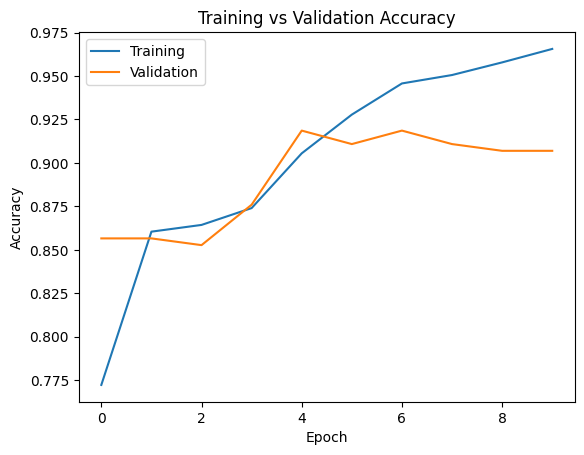

In [141]:
plt.plot(history.history['accuracy'], label="Training")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Training vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Based on the graph we can see that our model started off underfitted before ending overfitted. The model would work best if we only trained it to about ~3 or 4 epoch.

In [142]:
model.evaluate(testData)

9/9 [==============================] - 2s 173ms/step - loss: 0.2260 - accuracy: 0.9419


[0.2259673923254013, 0.9418604373931885]

Finally we get a pretty good accuracy score for out test dataset. Some limitations of this program is  the size of the main dataset given. There was only about 2600 ramen in the dataset. Something that can be improved upon is that we could instead of having a classification of 2 categories, have more categories for the different countries.